# DC-TSS Example with PAMAP2 

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
from numpy import genfromtxt
import matplotlib.pyplot as plt
import os
import csv
from scipy import stats as st
from utils import *

import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets


import numpy as np
import matplotlib.pyplot as plt
import os
import torch.nn.functional as F
from torch.autograd import Variable
import math
from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial import distance
from TS_DEC import *
#from TS_DEC_Linear import *


from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from scipy.spatial.distance import cosine as cosine_distance
from typing import Optional, List
from scipy.io import arff

from scipy.signal import find_peaks

import warnings
warnings.filterwarnings('ignore')

## Set Parameters

In [2]:
# Hyper parameters for Neural Network
epochs1 = 1200
epochs2 = 8000
lr=0.1
pre_lr = 1.5e-3
layers = [10,8,8,3]
strides = [3,3,3,3]
batch_size = 1500

# DC-TSS hyper-parameters
window_length = 160
overlap_percent = 0.2
n_clusters = 80
window_length2 = 50



## Read Dataset

In [3]:
#selected_songs = [2,140,30056,30058,85594,120308,120194,120112,120105]
time_series = np.loadtxt("./data/PAMAP2.csv", delimiter=",")
labels = np.loadtxt("./data/PAMAP2_labels.csv", delimiter=",")
ground_truth = np.where(labels[:-1] != labels[1:])[0]


## Subsequence TS

In [4]:
start = 0
subsequences = []
subsequence_labels = []

while start+window_length < len(time_series[0]):
    subsequence_labels.append(st.mode(labels[start:start+window_length])[0][0])    
    subsequence = time_series[:,start:start+window_length]
    start = start+window_length - int(overlap_percent*window_length)
    subsequences.append(subsequence)

subsequences = np.asarray(subsequences)
subsequence_labels = np.asarray(subsequence_labels)
batch_size = subsequences.shape[0]

## Set Data_loader for Neural Network?

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


data_loader = get_dataloader(data=subsequences,
                          shuffle=False,
                          batch_size=batch_size,
                          num_workers=1,
                          data_transforms=None)
torch.cuda.empty_cache()
input_shape = subsequences.shape
#torch.cuda.memory_summary(device=None, abbreviated=False)



cuda


In [6]:
inputs = torch.rand(40,160)
print(inputs.shape)
mod =  nn.Conv1d(40, 40, 10, stride=3)
out = mod(inputs)
print(out.shape)

mod =  nn.Conv1d(40, 40, 8, stride=3)
out = mod(out)
print(out.shape)

mod =  nn.Conv1d(40, 40, 8, stride=3)
out = mod(out)
print(out.shape)

mod =  nn.Conv1d(40, 40, 3, stride=3)
out = mod(out)
print(out.shape)


torch.Size([40, 160])
torch.Size([40, 51])
torch.Size([40, 15])
torch.Size([40, 3])
torch.Size([40, 1])


## Create DC-TSS model

In [7]:
deep_cluster_model = DEC(n_clusters = n_clusters, input_shape=input_shape,k_sizes=layers,strides=strides)
deep_cluster_model.to(device)


DEC(
  (AE): Autoencoder(
    (encoder): Sequential(
      (0): Conv1d(40, 40, kernel_size=(10,), stride=(3,))
      (1): LeakyReLU(negative_slope=0.1)
      (2): Conv1d(40, 40, kernel_size=(8,), stride=(3,))
      (3): LeakyReLU(negative_slope=0.1)
      (4): Conv1d(40, 40, kernel_size=(8,), stride=(3,))
      (5): LeakyReLU(negative_slope=0.1)
      (6): Conv1d(40, 40, kernel_size=(3,), stride=(3,))
    )
    (decoder): Sequential(
      (0): ConvTranspose1d(40, 40, kernel_size=(3,), stride=(3,))
      (1): LeakyReLU(negative_slope=0.1)
      (2): ConvTranspose1d(40, 40, kernel_size=(8,), stride=(3,))
      (3): LeakyReLU(negative_slope=0.1)
      (4): ConvTranspose1d(40, 40, kernel_size=(8,), stride=(3,))
      (5): LeakyReLU(negative_slope=0.1)
      (6): ConvTranspose1d(40, 40, kernel_size=(10,), stride=(3,))
      (7): LeakyReLU(negative_slope=0.1)
      (8): Upsample(size=160, mode=nearest)
    )
  )
  (clustlayer): clustering()
  (model): Sequential(
    (0): Sequential(
      

## Phase 1: Initialize Latent Space Mapping with 1DCNN AE

In [8]:
pretraining(model=deep_cluster_model, dbgenerator=data_loader, batch_size=batch_size, epochs=epochs1,lr=pre_lr)


epoch 1,loss = 0.99926162
epoch 2,loss = 0.99911547
epoch 3,loss = 0.99898851
epoch 4,loss = 0.99886042
epoch 5,loss = 0.99868876
epoch 6,loss = 0.99837041
epoch 7,loss = 0.99757206
epoch 8,loss = 0.99562567
epoch 9,loss = 0.99121034
epoch 10,loss = 0.98208481
epoch 11,loss = 0.96663213
epoch 12,loss = 0.95764309
epoch 13,loss = 0.95473641
epoch 14,loss = 0.93896174
epoch 15,loss = 0.93343943
epoch 16,loss = 0.93136567
epoch 17,loss = 0.92351806
epoch 18,loss = 0.91596580
epoch 19,loss = 0.91504931
epoch 20,loss = 0.91107368
epoch 21,loss = 0.90503532
epoch 22,loss = 0.90206909
epoch 23,loss = 0.89951396
epoch 24,loss = 0.89595789
epoch 25,loss = 0.89149857
epoch 26,loss = 0.88894552
epoch 27,loss = 0.88551724
epoch 28,loss = 0.88126093
epoch 29,loss = 0.87745118
epoch 30,loss = 0.87394315
epoch 31,loss = 0.86993629
epoch 32,loss = 0.86606497
epoch 33,loss = 0.86317986
epoch 34,loss = 0.86137128
epoch 35,loss = 0.85981947
epoch 36,loss = 0.85854149
epoch 37,loss = 0.85749549
epoch 38,l

epoch 298,loss = 0.49310657
epoch 299,loss = 0.49365985
epoch 300,loss = 0.49444219
epoch 301,loss = 0.49425671
epoch 302,loss = 0.49429634
epoch 303,loss = 0.49131092
epoch 304,loss = 0.48926005
epoch 305,loss = 0.48851165
epoch 306,loss = 0.48895925
epoch 307,loss = 0.48789456
epoch 308,loss = 0.48571536
epoch 309,loss = 0.48494649
epoch 310,loss = 0.48504514
epoch 311,loss = 0.48420715
epoch 312,loss = 0.48240674
epoch 313,loss = 0.48178720
epoch 314,loss = 0.48150116
epoch 315,loss = 0.48099357
epoch 316,loss = 0.47990829
epoch 317,loss = 0.47891551
epoch 318,loss = 0.47822052
epoch 319,loss = 0.47778785
epoch 320,loss = 0.47744137
epoch 321,loss = 0.47663128
epoch 322,loss = 0.47562650
epoch 323,loss = 0.47469920
epoch 324,loss = 0.47423252
epoch 325,loss = 0.47376892
epoch 326,loss = 0.47318533
epoch 327,loss = 0.47249991
epoch 328,loss = 0.47187358
epoch 329,loss = 0.47163001
epoch 330,loss = 0.47145367
epoch 331,loss = 0.47145239
epoch 332,loss = 0.47089732
epoch 333,loss = 0.4

epoch 591,loss = 0.38986501
epoch 592,loss = 0.38974351
epoch 593,loss = 0.38981253
epoch 594,loss = 0.38945690
epoch 595,loss = 0.38889652
epoch 596,loss = 0.38864973
epoch 597,loss = 0.38879037
epoch 598,loss = 0.38861176
epoch 599,loss = 0.38814551
epoch 600,loss = 0.38772380
epoch 601,loss = 0.38755101
epoch 602,loss = 0.38755938
epoch 603,loss = 0.38745910
epoch 604,loss = 0.38721731
epoch 605,loss = 0.38711819
epoch 606,loss = 0.38720104
epoch 607,loss = 0.38733721
epoch 608,loss = 0.38750923
epoch 609,loss = 0.38780904
epoch 610,loss = 0.38772416
epoch 611,loss = 0.38739961
epoch 612,loss = 0.38702989
epoch 613,loss = 0.38727757
epoch 614,loss = 0.38743204
epoch 615,loss = 0.38739812
epoch 616,loss = 0.38683313
epoch 617,loss = 0.38554427
epoch 618,loss = 0.38524324
epoch 619,loss = 0.38567889
epoch 620,loss = 0.38534406
epoch 621,loss = 0.38495579
epoch 622,loss = 0.38480076
epoch 623,loss = 0.38447487
epoch 624,loss = 0.38373357
epoch 625,loss = 0.38302249
epoch 626,loss = 0.3

epoch 884,loss = 0.34640273
epoch 885,loss = 0.34607285
epoch 886,loss = 0.34692889
epoch 887,loss = 0.34728280
epoch 888,loss = 0.34639242
epoch 889,loss = 0.34492770
epoch 890,loss = 0.34486139
epoch 891,loss = 0.34551290
epoch 892,loss = 0.34541613
epoch 893,loss = 0.34480491
epoch 894,loss = 0.34444770
epoch 895,loss = 0.34461194
epoch 896,loss = 0.34467655
epoch 897,loss = 0.34418443
epoch 898,loss = 0.34375027
epoch 899,loss = 0.34380448
epoch 900,loss = 0.34416437
epoch 901,loss = 0.34441009
epoch 902,loss = 0.34417513
epoch 903,loss = 0.34389141
epoch 904,loss = 0.34372401
epoch 905,loss = 0.34357011
epoch 906,loss = 0.34330764
epoch 907,loss = 0.34297773
epoch 908,loss = 0.34291115
epoch 909,loss = 0.34317103
epoch 910,loss = 0.34382740
epoch 911,loss = 0.34411660
epoch 912,loss = 0.34431511
epoch 913,loss = 0.34396356
epoch 914,loss = 0.34427333
epoch 915,loss = 0.34326679
epoch 916,loss = 0.34270048
epoch 917,loss = 0.34228268
epoch 918,loss = 0.34250757
epoch 919,loss = 0.3

epoch 1171,loss = 0.32043013
epoch 1172,loss = 0.32050499
epoch 1173,loss = 0.32029423
epoch 1174,loss = 0.31986442
epoch 1175,loss = 0.32001716
epoch 1176,loss = 0.32040024
epoch 1177,loss = 0.32054386
epoch 1178,loss = 0.31970528
epoch 1179,loss = 0.31878453
epoch 1180,loss = 0.31853145
epoch 1181,loss = 0.31874800
epoch 1182,loss = 0.31914195
epoch 1183,loss = 0.31918874
epoch 1184,loss = 0.31907517
epoch 1185,loss = 0.31857798
epoch 1186,loss = 0.31817779
epoch 1187,loss = 0.31793103
epoch 1188,loss = 0.31806704
epoch 1189,loss = 0.31839418
epoch 1190,loss = 0.31854403
epoch 1191,loss = 0.31851003
epoch 1192,loss = 0.31838843
epoch 1193,loss = 0.31871507
epoch 1194,loss = 0.31862968
epoch 1195,loss = 0.31862995
epoch 1196,loss = 0.31797040
epoch 1197,loss = 0.31745946
epoch 1198,loss = 0.31718725
epoch 1199,loss = 0.31721541
epoch 1200,loss = 0.31751654


In [114]:
torch.save(deep_cluster_model.state_dict(), './PAMAP2_pretrain_example.pth')

In [106]:
deep_cluster_model = DEC(n_clusters = n_clusters, input_shape=input_shape,k_sizes=layers,strides=strides)
deep_cluster_model.load_state_dict(torch.load('./PAMAP2_pretrain_exampl.pth'))
deep_cluster_model.to(device)

DEC(
  (AE): Autoencoder(
    (encoder): Sequential(
      (0): Conv1d(40, 40, kernel_size=(10,), stride=(3,))
      (1): LeakyReLU(negative_slope=0.1)
      (2): Conv1d(40, 40, kernel_size=(8,), stride=(3,))
      (3): LeakyReLU(negative_slope=0.1)
      (4): Conv1d(40, 40, kernel_size=(8,), stride=(3,))
      (5): LeakyReLU(negative_slope=0.1)
      (6): Conv1d(40, 40, kernel_size=(3,), stride=(3,))
    )
    (decoder): Sequential(
      (0): ConvTranspose1d(40, 40, kernel_size=(3,), stride=(3,))
      (1): LeakyReLU(negative_slope=0.1)
      (2): ConvTranspose1d(40, 40, kernel_size=(8,), stride=(3,))
      (3): LeakyReLU(negative_slope=0.1)
      (4): ConvTranspose1d(40, 40, kernel_size=(8,), stride=(3,))
      (5): LeakyReLU(negative_slope=0.1)
      (6): ConvTranspose1d(40, 40, kernel_size=(10,), stride=(3,))
      (7): LeakyReLU(negative_slope=0.1)
      (8): Upsample(size=160, mode=nearest)
    )
  )
  (clustlayer): clustering()
  (model): Sequential(
    (0): Sequential(
      

## Phase 2: Refine Latent Space and Find Clusters

In [107]:
cluster_assignments = refine_clusters(100, data_loader, deep_cluster_model, device, epochs2, batch_size, lr, 0.0, 1)


Initializing cluster centers with k-means. number of clusters 100
torch.Size([2940, 40, 160])
1.0
Epoch 1:   loss= 0.4862
Epoch 2:   loss= 0.48876
Epoch 3:   loss= 0.50371
Epoch 4:   loss= 0.50289
Epoch 5:   loss= 0.51266
Epoch 6:   loss= 0.50638
Epoch 7:   loss= 0.51446
Epoch 8:   loss= 0.5071
Epoch 9:   loss= 0.51191
Epoch 10:   loss= 0.50549
Epoch 11:   loss= 0.50914
Epoch 12:   loss= 0.50534
Epoch 13:   loss= 0.50881
Epoch 14:   loss= 0.50532
Epoch 15:   loss= 0.5081
Epoch 16:   loss= 0.50547
Epoch 17:   loss= 0.50792
Epoch 18:   loss= 0.50411
Epoch 19:   loss= 0.50609
Epoch 20:   loss= 0.50594
Epoch 21:   loss= 0.50537
Epoch 22:   loss= 0.50656
Epoch 23:   loss= 0.50422
Epoch 24:   loss= 0.50426
Epoch 25:   loss= 0.50456
Epoch 26:   loss= 0.50373
Epoch 27:   loss= 0.50366
Epoch 28:   loss= 0.50357
Epoch 29:   loss= 0.50344
Epoch 30:   loss= 0.50259
Epoch 31:   loss= 0.50222
Epoch 32:   loss= 0.50191
Epoch 33:   loss= 0.50225
Epoch 34:   loss= 0.50294
Epoch 35:   loss= 0.50234
Epoc

Epoch 314:   loss= 0.50381
Epoch 315:   loss= 0.50375
Epoch 316:   loss= 0.50367
Epoch 317:   loss= 0.5036
Epoch 318:   loss= 0.50353
Epoch 319:   loss= 0.50347
Epoch 320:   loss= 0.50339
Epoch 321:   loss= 0.50333
Epoch 322:   loss= 0.50325
Epoch 323:   loss= 0.50319
Epoch 324:   loss= 0.50311
Epoch 325:   loss= 0.50305
Epoch 326:   loss= 0.50298
Epoch 327:   loss= 0.50291
Epoch 328:   loss= 0.50284
Epoch 329:   loss= 0.50278
Epoch 330:   loss= 0.5027
Epoch 331:   loss= 0.50264
Epoch 332:   loss= 0.50257
Epoch 333:   loss= 0.5025
Epoch 334:   loss= 0.50243
Epoch 335:   loss= 0.50237
Epoch 336:   loss= 0.50229
Epoch 337:   loss= 0.50223
Epoch 338:   loss= 0.50216
Epoch 339:   loss= 0.50209
Epoch 340:   loss= 0.50202
Epoch 341:   loss= 0.50196
Epoch 342:   loss= 0.50189
Epoch 343:   loss= 0.50183
Epoch 344:   loss= 0.50176
Epoch 345:   loss= 0.50169
Epoch 346:   loss= 0.50162
Epoch 347:   loss= 0.50156
Epoch 348:   loss= 0.50149
Epoch 349:   loss= 0.50143
Epoch 350:   loss= 0.50136
Epoc

Epoch 626:   loss= 0.49028
Epoch 627:   loss= 0.49026
Epoch 628:   loss= 0.49022
Epoch 629:   loss= 0.4902
Epoch 630:   loss= 0.49017
Epoch 631:   loss= 0.49015
Epoch 632:   loss= 0.49011
Epoch 633:   loss= 0.4901
Epoch 634:   loss= 0.49006
Epoch 635:   loss= 0.49005
Epoch 636:   loss= 0.49001
Epoch 637:   loss= 0.48999
Epoch 638:   loss= 0.48996
Epoch 639:   loss= 0.48994
Epoch 640:   loss= 0.4899
Epoch 641:   loss= 0.48988
Epoch 642:   loss= 0.48985
Epoch 643:   loss= 0.48983
Epoch 644:   loss= 0.48979
Epoch 645:   loss= 0.48977
Epoch 646:   loss= 0.48973
Epoch 647:   loss= 0.48971
Epoch 648:   loss= 0.48968
Epoch 649:   loss= 0.48966
Epoch 650:   loss= 0.48962
Epoch 651:   loss= 0.4896
Epoch 652:   loss= 0.48956
Epoch 653:   loss= 0.48954
Epoch 654:   loss= 0.4895
Epoch 655:   loss= 0.48948
Epoch 656:   loss= 0.48944
Epoch 657:   loss= 0.48942
Epoch 658:   loss= 0.48938
Epoch 659:   loss= 0.48935
Epoch 660:   loss= 0.48931
Epoch 661:   loss= 0.48929
Epoch 662:   loss= 0.48925
Epoch 

Epoch 939:   loss= 0.48053
Epoch 940:   loss= 0.48049
Epoch 941:   loss= 0.48047
Epoch 942:   loss= 0.48043
Epoch 943:   loss= 0.48041
Epoch 944:   loss= 0.48037
Epoch 945:   loss= 0.48036
Epoch 946:   loss= 0.48032
Epoch 947:   loss= 0.4803
Epoch 948:   loss= 0.48026
Epoch 949:   loss= 0.48024
Epoch 950:   loss= 0.4802
Epoch 951:   loss= 0.48018
Epoch 952:   loss= 0.48014
Epoch 953:   loss= 0.48012
Epoch 954:   loss= 0.48008
Epoch 955:   loss= 0.48007
Epoch 956:   loss= 0.48003
Epoch 957:   loss= 0.48001
Epoch 958:   loss= 0.47997
Epoch 959:   loss= 0.47995
Epoch 960:   loss= 0.47991
Epoch 961:   loss= 0.47989
Epoch 962:   loss= 0.47985
Epoch 963:   loss= 0.47984
Epoch 964:   loss= 0.4798
Epoch 965:   loss= 0.47978
Epoch 966:   loss= 0.47974
Epoch 967:   loss= 0.47972
Epoch 968:   loss= 0.47968
Epoch 969:   loss= 0.47967
Epoch 970:   loss= 0.47963
Epoch 971:   loss= 0.47961
Epoch 972:   loss= 0.47957
Epoch 973:   loss= 0.47955
Epoch 974:   loss= 0.47951
Epoch 975:   loss= 0.47949
Epoc

Epoch 1237:   loss= 0.47364
Epoch 1238:   loss= 0.4736
Epoch 1239:   loss= 0.47359
Epoch 1240:   loss= 0.47356
Epoch 1241:   loss= 0.47355
Epoch 1242:   loss= 0.47351
Epoch 1243:   loss= 0.4735
Epoch 1244:   loss= 0.47347
Epoch 1245:   loss= 0.47345
Epoch 1246:   loss= 0.47342
Epoch 1247:   loss= 0.47341
Epoch 1248:   loss= 0.47338
Epoch 1249:   loss= 0.47336
Epoch 1250:   loss= 0.47333
Epoch 1251:   loss= 0.47332
Epoch 1252:   loss= 0.47328
Epoch 1253:   loss= 0.47327
Epoch 1254:   loss= 0.47324
Epoch 1255:   loss= 0.47322
Epoch 1256:   loss= 0.47319
Epoch 1257:   loss= 0.47318
Epoch 1258:   loss= 0.47315
Epoch 1259:   loss= 0.47313
Epoch 1260:   loss= 0.4731
Epoch 1261:   loss= 0.47309
Epoch 1262:   loss= 0.47306
Epoch 1263:   loss= 0.47304
Epoch 1264:   loss= 0.47301
Epoch 1265:   loss= 0.473
Epoch 1266:   loss= 0.47296
Epoch 1267:   loss= 0.47295
Epoch 1268:   loss= 0.47292
Epoch 1269:   loss= 0.47291
Epoch 1270:   loss= 0.47287
Epoch 1271:   loss= 0.47286
Epoch 1272:   loss= 0.472

Epoch 1538:   loss= 0.4673
Epoch 1539:   loss= 0.46729
Epoch 1540:   loss= 0.46727
Epoch 1541:   loss= 0.46726
Epoch 1542:   loss= 0.46723
Epoch 1543:   loss= 0.46722
Epoch 1544:   loss= 0.46719
Epoch 1545:   loss= 0.46718
Epoch 1546:   loss= 0.46715
Epoch 1547:   loss= 0.46714
Epoch 1548:   loss= 0.46712
Epoch 1549:   loss= 0.46711
Epoch 1550:   loss= 0.46708
Epoch 1551:   loss= 0.46707
Epoch 1552:   loss= 0.46704
Epoch 1553:   loss= 0.46703
Epoch 1554:   loss= 0.467
Epoch 1555:   loss= 0.46699
Epoch 1556:   loss= 0.46697
Epoch 1557:   loss= 0.46696
Epoch 1558:   loss= 0.46693
Epoch 1559:   loss= 0.46692
Epoch 1560:   loss= 0.46689
Epoch 1561:   loss= 0.46688
Epoch 1562:   loss= 0.46686
Epoch 1563:   loss= 0.46685
Epoch 1564:   loss= 0.46682
Epoch 1565:   loss= 0.46681
Epoch 1566:   loss= 0.46678
Epoch 1567:   loss= 0.46677
Epoch 1568:   loss= 0.46674
Epoch 1569:   loss= 0.46673
Epoch 1570:   loss= 0.46671
Epoch 1571:   loss= 0.4667
Epoch 1572:   loss= 0.46667
Epoch 1573:   loss= 0.46

Epoch 1837:   loss= 0.46279
Epoch 1838:   loss= 0.46278
Epoch 1839:   loss= 0.46276
Epoch 1840:   loss= 0.46276
Epoch 1841:   loss= 0.46274
Epoch 1842:   loss= 0.46273
Epoch 1843:   loss= 0.46271
Epoch 1844:   loss= 0.4627
Epoch 1845:   loss= 0.46268
Epoch 1846:   loss= 0.46267
Epoch 1847:   loss= 0.46266
Epoch 1848:   loss= 0.46265
Epoch 1849:   loss= 0.46263
Epoch 1850:   loss= 0.46262
Epoch 1851:   loss= 0.4626
Epoch 1852:   loss= 0.46259
Epoch 1853:   loss= 0.46257
Epoch 1854:   loss= 0.46256
Epoch 1855:   loss= 0.46254
Epoch 1856:   loss= 0.46253
Epoch 1857:   loss= 0.46251
Epoch 1858:   loss= 0.46249
Epoch 1859:   loss= 0.46247
Epoch 1860:   loss= 0.46246
Epoch 1861:   loss= 0.46244
Epoch 1862:   loss= 0.46243
Epoch 1863:   loss= 0.46241
Epoch 1864:   loss= 0.4624
Epoch 1865:   loss= 0.46238
Epoch 1866:   loss= 0.46236
Epoch 1867:   loss= 0.46234
Epoch 1868:   loss= 0.46233
Epoch 1869:   loss= 0.46231
Epoch 1870:   loss= 0.4623
Epoch 1871:   loss= 0.46228
Epoch 1872:   loss= 0.46

Epoch 2134:   loss= 0.45862
Epoch 2135:   loss= 0.4586
Epoch 2136:   loss= 0.45859
Epoch 2137:   loss= 0.45857
Epoch 2138:   loss= 0.45857
Epoch 2139:   loss= 0.45855
Epoch 2140:   loss= 0.45854
Epoch 2141:   loss= 0.45852
Epoch 2142:   loss= 0.45851
Epoch 2143:   loss= 0.45849
Epoch 2144:   loss= 0.45849
Epoch 2145:   loss= 0.45847
Epoch 2146:   loss= 0.45846
Epoch 2147:   loss= 0.45844
Epoch 2148:   loss= 0.45843
Epoch 2149:   loss= 0.45841
Epoch 2150:   loss= 0.45841
Epoch 2151:   loss= 0.45839
Epoch 2152:   loss= 0.45838
Epoch 2153:   loss= 0.45836
Epoch 2154:   loss= 0.45835
Epoch 2155:   loss= 0.45833
Epoch 2156:   loss= 0.45832
Epoch 2157:   loss= 0.45831
Epoch 2158:   loss= 0.4583
Epoch 2159:   loss= 0.45828
Epoch 2160:   loss= 0.45827
Epoch 2161:   loss= 0.45825
Epoch 2162:   loss= 0.45824
Epoch 2163:   loss= 0.45822
Epoch 2164:   loss= 0.45822
Epoch 2165:   loss= 0.4582
Epoch 2166:   loss= 0.45819
Epoch 2167:   loss= 0.45817
Epoch 2168:   loss= 0.45816
Epoch 2169:   loss= 0.4

Epoch 2433:   loss= 0.45475
Epoch 2434:   loss= 0.45474
Epoch 2435:   loss= 0.45472
Epoch 2436:   loss= 0.45472
Epoch 2437:   loss= 0.4547
Epoch 2438:   loss= 0.45469
Epoch 2439:   loss= 0.45467
Epoch 2440:   loss= 0.45467
Epoch 2441:   loss= 0.45465
Epoch 2442:   loss= 0.45464
Epoch 2443:   loss= 0.45462
Epoch 2444:   loss= 0.45462
Epoch 2445:   loss= 0.4546
Epoch 2446:   loss= 0.45459
Epoch 2447:   loss= 0.45458
Epoch 2448:   loss= 0.45457
Epoch 2449:   loss= 0.45455
Epoch 2450:   loss= 0.45454
Epoch 2451:   loss= 0.45453
Epoch 2452:   loss= 0.45452
Epoch 2453:   loss= 0.4545
Epoch 2454:   loss= 0.45449
Epoch 2455:   loss= 0.45448
Epoch 2456:   loss= 0.45447
Epoch 2457:   loss= 0.45445
Epoch 2458:   loss= 0.45445
Epoch 2459:   loss= 0.45443
Epoch 2460:   loss= 0.45442
Epoch 2461:   loss= 0.4544
Epoch 2462:   loss= 0.4544
Epoch 2463:   loss= 0.45438
Epoch 2464:   loss= 0.45437
Epoch 2465:   loss= 0.45435
Epoch 2466:   loss= 0.45435
Epoch 2467:   loss= 0.45433
Epoch 2468:   loss= 0.454

Epoch 2734:   loss= 0.45146
Epoch 2735:   loss= 0.45145
Epoch 2736:   loss= 0.45145
Epoch 2737:   loss= 0.45144
Epoch 2738:   loss= 0.45143
Epoch 2739:   loss= 0.45143
Epoch 2740:   loss= 0.45142
Epoch 2741:   loss= 0.45141
Epoch 2742:   loss= 0.45141
Epoch 2743:   loss= 0.4514
Epoch 2744:   loss= 0.4514
Epoch 2745:   loss= 0.45139
Epoch 2746:   loss= 0.45138
Epoch 2747:   loss= 0.45137
Epoch 2748:   loss= 0.45137
Epoch 2749:   loss= 0.45136
Epoch 2750:   loss= 0.45135
Epoch 2751:   loss= 0.45135
Epoch 2752:   loss= 0.45134
Epoch 2753:   loss= 0.45133
Epoch 2754:   loss= 0.45132
Epoch 2755:   loss= 0.45131
Epoch 2756:   loss= 0.45131
Epoch 2757:   loss= 0.4513
Epoch 2758:   loss= 0.45129
Epoch 2759:   loss= 0.45128
Epoch 2760:   loss= 0.45127
Epoch 2761:   loss= 0.45126
Epoch 2762:   loss= 0.45125
Epoch 2763:   loss= 0.45124
Epoch 2764:   loss= 0.45123
Epoch 2765:   loss= 0.45122
Epoch 2766:   loss= 0.45121
Epoch 2767:   loss= 0.45119
Epoch 2768:   loss= 0.45118
Epoch 2769:   loss= 0.4

Epoch 3037:   loss= 0.44737
Epoch 3038:   loss= 0.44736
Epoch 3039:   loss= 0.44736
Epoch 3040:   loss= 0.44736
Epoch 3041:   loss= 0.44735
Epoch 3042:   loss= 0.44735
Epoch 3043:   loss= 0.44734
Epoch 3044:   loss= 0.44733
Epoch 3045:   loss= 0.44733
Epoch 3046:   loss= 0.44732
Epoch 3047:   loss= 0.44732
Epoch 3048:   loss= 0.44731
Epoch 3049:   loss= 0.4473
Epoch 3050:   loss= 0.44729
Epoch 3051:   loss= 0.44729
Epoch 3052:   loss= 0.44727
Epoch 3053:   loss= 0.44727
Epoch 3054:   loss= 0.44726
Epoch 3055:   loss= 0.44725
Epoch 3056:   loss= 0.44724
Epoch 3057:   loss= 0.44723
Epoch 3058:   loss= 0.44722
Epoch 3059:   loss= 0.44722
Epoch 3060:   loss= 0.4472
Epoch 3061:   loss= 0.4472
Epoch 3062:   loss= 0.44719
Epoch 3063:   loss= 0.44718
Epoch 3064:   loss= 0.44717
Epoch 3065:   loss= 0.44716
Epoch 3066:   loss= 0.44715
Epoch 3067:   loss= 0.44714
Epoch 3068:   loss= 0.44713
Epoch 3069:   loss= 0.44712
Epoch 3070:   loss= 0.44711
Epoch 3071:   loss= 0.4471
Epoch 3072:   loss= 0.44

Epoch 3338:   loss= 0.44488
Epoch 3339:   loss= 0.44488
Epoch 3340:   loss= 0.44487
Epoch 3341:   loss= 0.44486
Epoch 3342:   loss= 0.44485
Epoch 3343:   loss= 0.44484
Epoch 3344:   loss= 0.44483
Epoch 3345:   loss= 0.44483
Epoch 3346:   loss= 0.44481
Epoch 3347:   loss= 0.44481
Epoch 3348:   loss= 0.4448
Epoch 3349:   loss= 0.44479
Epoch 3350:   loss= 0.44478
Epoch 3351:   loss= 0.44477
Epoch 3352:   loss= 0.44476
Epoch 3353:   loss= 0.44476
Epoch 3354:   loss= 0.44474
Epoch 3355:   loss= 0.44474
Epoch 3356:   loss= 0.44473
Epoch 3357:   loss= 0.44472
Epoch 3358:   loss= 0.44471
Epoch 3359:   loss= 0.4447
Epoch 3360:   loss= 0.44469
Epoch 3361:   loss= 0.44469
Epoch 3362:   loss= 0.44467
Epoch 3363:   loss= 0.44467
Epoch 3364:   loss= 0.44465
Epoch 3365:   loss= 0.44465
Epoch 3366:   loss= 0.44464
Epoch 3367:   loss= 0.44463
Epoch 3368:   loss= 0.44462
Epoch 3369:   loss= 0.44461
Epoch 3370:   loss= 0.4446
Epoch 3371:   loss= 0.4446
Epoch 3372:   loss= 0.44458
Epoch 3373:   loss= 0.44

Epoch 3639:   loss= 0.4422
Epoch 3640:   loss= 0.44219
Epoch 3641:   loss= 0.44218
Epoch 3642:   loss= 0.44217
Epoch 3643:   loss= 0.44217
Epoch 3644:   loss= 0.44215
Epoch 3645:   loss= 0.44215
Epoch 3646:   loss= 0.44214
Epoch 3647:   loss= 0.44213
Epoch 3648:   loss= 0.44212
Epoch 3649:   loss= 0.44211
Epoch 3650:   loss= 0.4421
Epoch 3651:   loss= 0.4421
Epoch 3652:   loss= 0.44208
Epoch 3653:   loss= 0.44208
Epoch 3654:   loss= 0.44206
Epoch 3655:   loss= 0.44206
Epoch 3656:   loss= 0.44205
Epoch 3657:   loss= 0.44204
Epoch 3658:   loss= 0.44203
Epoch 3659:   loss= 0.44202
Epoch 3660:   loss= 0.44201
Epoch 3661:   loss= 0.44201
Epoch 3662:   loss= 0.44199
Epoch 3663:   loss= 0.44199
Epoch 3664:   loss= 0.44198
Epoch 3665:   loss= 0.44197
Epoch 3666:   loss= 0.44196
Epoch 3667:   loss= 0.44195
Epoch 3668:   loss= 0.44194
Epoch 3669:   loss= 0.44193
Epoch 3670:   loss= 0.44192
Epoch 3671:   loss= 0.44192
Epoch 3672:   loss= 0.4419
Epoch 3673:   loss= 0.4419
Epoch 3674:   loss= 0.441

Epoch 3933:   loss= 0.43959
Epoch 3934:   loss= 0.43958
Epoch 3935:   loss= 0.43957
Epoch 3936:   loss= 0.43956
Epoch 3937:   loss= 0.43956
Epoch 3938:   loss= 0.43954
Epoch 3939:   loss= 0.43954
Epoch 3940:   loss= 0.43953
Epoch 3941:   loss= 0.43952
Epoch 3942:   loss= 0.43951
Epoch 3943:   loss= 0.4395
Epoch 3944:   loss= 0.43949
Epoch 3945:   loss= 0.43949
Epoch 3946:   loss= 0.43947
Epoch 3947:   loss= 0.43947
Epoch 3948:   loss= 0.43946
Epoch 3949:   loss= 0.43945
Epoch 3950:   loss= 0.43944
Epoch 3951:   loss= 0.43943
Epoch 3952:   loss= 0.43942
Epoch 3953:   loss= 0.43942
Epoch 3954:   loss= 0.4394
Epoch 3955:   loss= 0.4394
Epoch 3956:   loss= 0.43939
Epoch 3957:   loss= 0.43938
Epoch 3958:   loss= 0.43937
Epoch 3959:   loss= 0.43936
Epoch 3960:   loss= 0.43935
Epoch 3961:   loss= 0.43935
Epoch 3962:   loss= 0.43933
Epoch 3963:   loss= 0.43933
Epoch 3964:   loss= 0.43932
Epoch 3965:   loss= 0.43931
Epoch 3966:   loss= 0.4393
Epoch 3967:   loss= 0.43929
Epoch 3968:   loss= 0.43

Epoch 4231:   loss= 0.43707
Epoch 4232:   loss= 0.43706
Epoch 4233:   loss= 0.43705
Epoch 4234:   loss= 0.43704
Epoch 4235:   loss= 0.43703
Epoch 4236:   loss= 0.43702
Epoch 4237:   loss= 0.43702
Epoch 4238:   loss= 0.437
Epoch 4239:   loss= 0.437
Epoch 4240:   loss= 0.43699
Epoch 4241:   loss= 0.43698
Epoch 4242:   loss= 0.43697
Epoch 4243:   loss= 0.43696
Epoch 4244:   loss= 0.43695
Epoch 4245:   loss= 0.43695
Epoch 4246:   loss= 0.43694
Epoch 4247:   loss= 0.43693
Epoch 4248:   loss= 0.43692
Epoch 4249:   loss= 0.43691
Epoch 4250:   loss= 0.4369
Epoch 4251:   loss= 0.4369
Epoch 4252:   loss= 0.43688
Epoch 4253:   loss= 0.43688
Epoch 4254:   loss= 0.43687
Epoch 4255:   loss= 0.43686
Epoch 4256:   loss= 0.43685
Epoch 4257:   loss= 0.43685
Epoch 4258:   loss= 0.43683
Epoch 4259:   loss= 0.43683
Epoch 4260:   loss= 0.43682
Epoch 4261:   loss= 0.43681
Epoch 4262:   loss= 0.4368
Epoch 4263:   loss= 0.43679
Epoch 4264:   loss= 0.43678
Epoch 4265:   loss= 0.43678
Epoch 4266:   loss= 0.43677

Epoch 4530:   loss= 0.43465
Epoch 4531:   loss= 0.43465
Epoch 4532:   loss= 0.43464
Epoch 4533:   loss= 0.43463
Epoch 4534:   loss= 0.43462
Epoch 4535:   loss= 0.43462
Epoch 4536:   loss= 0.43461
Epoch 4537:   loss= 0.43461
Epoch 4538:   loss= 0.4346
Epoch 4539:   loss= 0.43459
Epoch 4540:   loss= 0.43458
Epoch 4541:   loss= 0.43458
Epoch 4542:   loss= 0.43457
Epoch 4543:   loss= 0.43456
Epoch 4544:   loss= 0.43455
Epoch 4545:   loss= 0.43455
Epoch 4546:   loss= 0.43454
Epoch 4547:   loss= 0.43453
Epoch 4548:   loss= 0.43452
Epoch 4549:   loss= 0.43451
Epoch 4550:   loss= 0.4345
Epoch 4551:   loss= 0.4345
Epoch 4552:   loss= 0.43449
Epoch 4553:   loss= 0.43448
Epoch 4554:   loss= 0.43447
Epoch 4555:   loss= 0.43446
Epoch 4556:   loss= 0.43445
Epoch 4557:   loss= 0.43445
Epoch 4558:   loss= 0.43444
Epoch 4559:   loss= 0.43443
Epoch 4560:   loss= 0.43442
Epoch 4561:   loss= 0.43441
Epoch 4562:   loss= 0.4344
Epoch 4563:   loss= 0.4344
Epoch 4564:   loss= 0.43439
Epoch 4565:   loss= 0.434

Epoch 4829:   loss= 0.43222
Epoch 4830:   loss= 0.43221
Epoch 4831:   loss= 0.43221
Epoch 4832:   loss= 0.4322
Epoch 4833:   loss= 0.43219
Epoch 4834:   loss= 0.43218
Epoch 4835:   loss= 0.43218
Epoch 4836:   loss= 0.43217
Epoch 4837:   loss= 0.43217
Epoch 4838:   loss= 0.43216
Epoch 4839:   loss= 0.43215
Epoch 4840:   loss= 0.43214
Epoch 4841:   loss= 0.43214
Epoch 4842:   loss= 0.43213
Epoch 4843:   loss= 0.43213
Epoch 4844:   loss= 0.43212
Epoch 4845:   loss= 0.43212
Epoch 4846:   loss= 0.43211
Epoch 4847:   loss= 0.4321
Epoch 4848:   loss= 0.4321
Epoch 4849:   loss= 0.43209
Epoch 4850:   loss= 0.43208
Epoch 4851:   loss= 0.43208
Epoch 4852:   loss= 0.43207
Epoch 4853:   loss= 0.43207
Epoch 4854:   loss= 0.43206
Epoch 4855:   loss= 0.43205
Epoch 4856:   loss= 0.43204
Epoch 4857:   loss= 0.43204
Epoch 4858:   loss= 0.43203
Epoch 4859:   loss= 0.43203
Epoch 4860:   loss= 0.43202
Epoch 4861:   loss= 0.43201
Epoch 4862:   loss= 0.432
Epoch 4863:   loss= 0.432
Epoch 4864:   loss= 0.43199

Epoch 5123:   loss= 0.42999
Epoch 5124:   loss= 0.42998
Epoch 5125:   loss= 0.42998
Epoch 5126:   loss= 0.42997
Epoch 5127:   loss= 0.42996
Epoch 5128:   loss= 0.42995
Epoch 5129:   loss= 0.42995
Epoch 5130:   loss= 0.42993
Epoch 5131:   loss= 0.42993
Epoch 5132:   loss= 0.42992
Epoch 5133:   loss= 0.42991
Epoch 5134:   loss= 0.4299
Epoch 5135:   loss= 0.4299
Epoch 5136:   loss= 0.42989
Epoch 5137:   loss= 0.42988
Epoch 5138:   loss= 0.42987
Epoch 5139:   loss= 0.42986
Epoch 5140:   loss= 0.42985
Epoch 5141:   loss= 0.42985
Epoch 5142:   loss= 0.42984
Epoch 5143:   loss= 0.42983
Epoch 5144:   loss= 0.42982
Epoch 5145:   loss= 0.42982
Epoch 5146:   loss= 0.42981
Epoch 5147:   loss= 0.4298
Epoch 5148:   loss= 0.42979
Epoch 5149:   loss= 0.42978
Epoch 5150:   loss= 0.42977
Epoch 5151:   loss= 0.42977
Epoch 5152:   loss= 0.42976
Epoch 5153:   loss= 0.42975
Epoch 5154:   loss= 0.42974
Epoch 5155:   loss= 0.42974
Epoch 5156:   loss= 0.42973
Epoch 5157:   loss= 0.42972
Epoch 5158:   loss= 0.4

Epoch 5418:   loss= 0.42781
Epoch 5419:   loss= 0.42781
Epoch 5420:   loss= 0.4278
Epoch 5421:   loss= 0.42779
Epoch 5422:   loss= 0.42778
Epoch 5423:   loss= 0.42778
Epoch 5424:   loss= 0.42777
Epoch 5425:   loss= 0.42776
Epoch 5426:   loss= 0.42775
Epoch 5427:   loss= 0.42774
Epoch 5428:   loss= 0.42773
Epoch 5429:   loss= 0.42773
Epoch 5430:   loss= 0.42772
Epoch 5431:   loss= 0.42771
Epoch 5432:   loss= 0.4277
Epoch 5433:   loss= 0.4277
Epoch 5434:   loss= 0.42769
Epoch 5435:   loss= 0.42768
Epoch 5436:   loss= 0.42767
Epoch 5437:   loss= 0.42767
Epoch 5438:   loss= 0.42766
Epoch 5439:   loss= 0.42765
Epoch 5440:   loss= 0.42764
Epoch 5441:   loss= 0.42763
Epoch 5442:   loss= 0.42762
Epoch 5443:   loss= 0.42762
Epoch 5444:   loss= 0.42761
Epoch 5445:   loss= 0.4276
Epoch 5446:   loss= 0.42759
Epoch 5447:   loss= 0.42759
Epoch 5448:   loss= 0.42758
Epoch 5449:   loss= 0.42757
Epoch 5450:   loss= 0.42756
Epoch 5451:   loss= 0.42756
Epoch 5452:   loss= 0.42755
Epoch 5453:   loss= 0.42

Epoch 5719:   loss= 0.4256
Epoch 5720:   loss= 0.42559
Epoch 5721:   loss= 0.42559
Epoch 5722:   loss= 0.42558
Epoch 5723:   loss= 0.42557
Epoch 5724:   loss= 0.42556
Epoch 5725:   loss= 0.42556
Epoch 5726:   loss= 0.42555
Epoch 5727:   loss= 0.42554
Epoch 5728:   loss= 0.42553
Epoch 5729:   loss= 0.42553
Epoch 5730:   loss= 0.42552
Epoch 5731:   loss= 0.42551
Epoch 5732:   loss= 0.4255
Epoch 5733:   loss= 0.4255
Epoch 5734:   loss= 0.42549
Epoch 5735:   loss= 0.42548
Epoch 5736:   loss= 0.42547
Epoch 5737:   loss= 0.42546
Epoch 5738:   loss= 0.42545
Epoch 5739:   loss= 0.42545
Epoch 5740:   loss= 0.42544
Epoch 5741:   loss= 0.42543
Epoch 5742:   loss= 0.42542
Epoch 5743:   loss= 0.42542
Epoch 5744:   loss= 0.42541
Epoch 5745:   loss= 0.4254
Epoch 5746:   loss= 0.42539
Epoch 5747:   loss= 0.42539
Epoch 5748:   loss= 0.42538
Epoch 5749:   loss= 0.42537
Epoch 5750:   loss= 0.42536
Epoch 5751:   loss= 0.42536
Epoch 5752:   loss= 0.42535
Epoch 5753:   loss= 0.42534
Epoch 5754:   loss= 0.42

Epoch 6021:   loss= 0.42342
Epoch 6022:   loss= 0.42341
Epoch 6023:   loss= 0.42341
Epoch 6024:   loss= 0.4234
Epoch 6025:   loss= 0.42339
Epoch 6026:   loss= 0.42338
Epoch 6027:   loss= 0.42338
Epoch 6028:   loss= 0.42337
Epoch 6029:   loss= 0.42336
Epoch 6030:   loss= 0.42335
Epoch 6031:   loss= 0.42335
Epoch 6032:   loss= 0.42334
Epoch 6033:   loss= 0.42333
Epoch 6034:   loss= 0.42332
Epoch 6035:   loss= 0.42332
Epoch 6036:   loss= 0.42331
Epoch 6037:   loss= 0.4233
Epoch 6038:   loss= 0.42329
Epoch 6039:   loss= 0.42329
Epoch 6040:   loss= 0.42328
Epoch 6041:   loss= 0.42327
Epoch 6042:   loss= 0.42326
Epoch 6043:   loss= 0.42325
Epoch 6044:   loss= 0.42325
Epoch 6045:   loss= 0.42324
Epoch 6046:   loss= 0.42323
Epoch 6047:   loss= 0.42322
Epoch 6048:   loss= 0.42321
Epoch 6049:   loss= 0.42321
Epoch 6050:   loss= 0.4232
Epoch 6051:   loss= 0.42319
Epoch 6052:   loss= 0.42318
Epoch 6053:   loss= 0.42318
Epoch 6054:   loss= 0.42317
Epoch 6055:   loss= 0.42316
Epoch 6056:   loss= 0.4

Epoch 6323:   loss= 0.42125
Epoch 6324:   loss= 0.42125
Epoch 6325:   loss= 0.42124
Epoch 6326:   loss= 0.42123
Epoch 6327:   loss= 0.42122
Epoch 6328:   loss= 0.42121
Epoch 6329:   loss= 0.42121
Epoch 6330:   loss= 0.4212
Epoch 6331:   loss= 0.42119
Epoch 6332:   loss= 0.42118
Epoch 6333:   loss= 0.42118
Epoch 6334:   loss= 0.42117
Epoch 6335:   loss= 0.42116
Epoch 6336:   loss= 0.42115
Epoch 6337:   loss= 0.42115
Epoch 6338:   loss= 0.42114
Epoch 6339:   loss= 0.42113
Epoch 6340:   loss= 0.42112
Epoch 6341:   loss= 0.42112
Epoch 6342:   loss= 0.42111
Epoch 6343:   loss= 0.4211
Epoch 6344:   loss= 0.42109
Epoch 6345:   loss= 0.42109
Epoch 6346:   loss= 0.42108
Epoch 6347:   loss= 0.42107
Epoch 6348:   loss= 0.42106
Epoch 6349:   loss= 0.42106
Epoch 6350:   loss= 0.42105
Epoch 6351:   loss= 0.42104
Epoch 6352:   loss= 0.42103
Epoch 6353:   loss= 0.42102
Epoch 6354:   loss= 0.42102
Epoch 6355:   loss= 0.42101
Epoch 6356:   loss= 0.421
Epoch 6357:   loss= 0.42099
Epoch 6358:   loss= 0.42

Epoch 6625:   loss= 0.41912
Epoch 6626:   loss= 0.41911
Epoch 6627:   loss= 0.41911
Epoch 6628:   loss= 0.4191
Epoch 6629:   loss= 0.41909
Epoch 6630:   loss= 0.41908
Epoch 6631:   loss= 0.41908
Epoch 6632:   loss= 0.41907
Epoch 6633:   loss= 0.41906
Epoch 6634:   loss= 0.41905
Epoch 6635:   loss= 0.41905
Epoch 6636:   loss= 0.41904
Epoch 6637:   loss= 0.41903
Epoch 6638:   loss= 0.41902
Epoch 6639:   loss= 0.41902
Epoch 6640:   loss= 0.41901
Epoch 6641:   loss= 0.419
Epoch 6642:   loss= 0.41899
Epoch 6643:   loss= 0.41899
Epoch 6644:   loss= 0.41898
Epoch 6645:   loss= 0.41897
Epoch 6646:   loss= 0.41896
Epoch 6647:   loss= 0.41896
Epoch 6648:   loss= 0.41895
Epoch 6649:   loss= 0.41894
Epoch 6650:   loss= 0.41893
Epoch 6651:   loss= 0.41893
Epoch 6652:   loss= 0.41892
Epoch 6653:   loss= 0.41891
Epoch 6654:   loss= 0.4189
Epoch 6655:   loss= 0.4189
Epoch 6656:   loss= 0.41889
Epoch 6657:   loss= 0.41888
Epoch 6658:   loss= 0.41887
Epoch 6659:   loss= 0.41887
Epoch 6660:   loss= 0.418

Epoch 6925:   loss= 0.41701
Epoch 6926:   loss= 0.417
Epoch 6927:   loss= 0.41699
Epoch 6928:   loss= 0.41698
Epoch 6929:   loss= 0.41698
Epoch 6930:   loss= 0.41697
Epoch 6931:   loss= 0.41696
Epoch 6932:   loss= 0.41695
Epoch 6933:   loss= 0.41695
Epoch 6934:   loss= 0.41694
Epoch 6935:   loss= 0.41693
Epoch 6936:   loss= 0.41692
Epoch 6937:   loss= 0.41692
Epoch 6938:   loss= 0.41691
Epoch 6939:   loss= 0.4169
Epoch 6940:   loss= 0.41689
Epoch 6941:   loss= 0.41689
Epoch 6942:   loss= 0.41688
Epoch 6943:   loss= 0.41687
Epoch 6944:   loss= 0.41686
Epoch 6945:   loss= 0.41686
Epoch 6946:   loss= 0.41685
Epoch 6947:   loss= 0.41684
Epoch 6948:   loss= 0.41683
Epoch 6949:   loss= 0.41683
Epoch 6950:   loss= 0.41682
Epoch 6951:   loss= 0.41681
Epoch 6952:   loss= 0.4168
Epoch 6953:   loss= 0.4168
Epoch 6954:   loss= 0.41679
Epoch 6955:   loss= 0.41678
Epoch 6956:   loss= 0.41677
Epoch 6957:   loss= 0.41677
Epoch 6958:   loss= 0.41676
Epoch 6959:   loss= 0.41675
Epoch 6960:   loss= 0.416

Epoch 7223:   loss= 0.41493
Epoch 7224:   loss= 0.41492
Epoch 7225:   loss= 0.41491
Epoch 7226:   loss= 0.4149
Epoch 7227:   loss= 0.4149
Epoch 7228:   loss= 0.41489
Epoch 7229:   loss= 0.41488
Epoch 7230:   loss= 0.41488
Epoch 7231:   loss= 0.41487
Epoch 7232:   loss= 0.41486
Epoch 7233:   loss= 0.41485
Epoch 7234:   loss= 0.41485
Epoch 7235:   loss= 0.41484
Epoch 7236:   loss= 0.41483
Epoch 7237:   loss= 0.41483
Epoch 7238:   loss= 0.41482
Epoch 7239:   loss= 0.41481
Epoch 7240:   loss= 0.4148
Epoch 7241:   loss= 0.4148
Epoch 7242:   loss= 0.41479
Epoch 7243:   loss= 0.41478
Epoch 7244:   loss= 0.41477
Epoch 7245:   loss= 0.41477
Epoch 7246:   loss= 0.41476
Epoch 7247:   loss= 0.41475
Epoch 7248:   loss= 0.41474
Epoch 7249:   loss= 0.41474
Epoch 7250:   loss= 0.41473
Epoch 7251:   loss= 0.41472
Epoch 7252:   loss= 0.41471
Epoch 7253:   loss= 0.41471
Epoch 7254:   loss= 0.4147
Epoch 7255:   loss= 0.41469
Epoch 7256:   loss= 0.41468
Epoch 7257:   loss= 0.41468
Epoch 7258:   loss= 0.414

Epoch 7523:   loss= 0.41278
Epoch 7524:   loss= 0.41278
Epoch 7525:   loss= 0.41277
Epoch 7526:   loss= 0.41277
Epoch 7527:   loss= 0.41276
Epoch 7528:   loss= 0.41276
Epoch 7529:   loss= 0.41275
Epoch 7530:   loss= 0.41275
Epoch 7531:   loss= 0.41274
Epoch 7532:   loss= 0.41273
Epoch 7533:   loss= 0.41273
Epoch 7534:   loss= 0.41272
Epoch 7535:   loss= 0.41272
Epoch 7536:   loss= 0.41271
Epoch 7537:   loss= 0.41271
Epoch 7538:   loss= 0.4127
Epoch 7539:   loss= 0.41269
Epoch 7540:   loss= 0.41269
Epoch 7541:   loss= 0.41268
Epoch 7542:   loss= 0.41268
Epoch 7543:   loss= 0.41267
Epoch 7544:   loss= 0.41266
Epoch 7545:   loss= 0.41266
Epoch 7546:   loss= 0.41265
Epoch 7547:   loss= 0.41264
Epoch 7548:   loss= 0.41264
Epoch 7549:   loss= 0.41263
Epoch 7550:   loss= 0.41262
Epoch 7551:   loss= 0.41262
Epoch 7552:   loss= 0.41261
Epoch 7553:   loss= 0.4126
Epoch 7554:   loss= 0.4126
Epoch 7555:   loss= 0.41259
Epoch 7556:   loss= 0.41258
Epoch 7557:   loss= 0.41258
Epoch 7558:   loss= 0.4

Epoch 7819:   loss= 0.41072
Epoch 7820:   loss= 0.41072
Epoch 7821:   loss= 0.41071
Epoch 7822:   loss= 0.4107
Epoch 7823:   loss= 0.4107
Epoch 7824:   loss= 0.41069
Epoch 7825:   loss= 0.41069
Epoch 7826:   loss= 0.41068
Epoch 7827:   loss= 0.41067
Epoch 7828:   loss= 0.41067
Epoch 7829:   loss= 0.41066
Epoch 7830:   loss= 0.41065
Epoch 7831:   loss= 0.41065
Epoch 7832:   loss= 0.41064
Epoch 7833:   loss= 0.41064
Epoch 7834:   loss= 0.41063
Epoch 7835:   loss= 0.41062
Epoch 7836:   loss= 0.41062
Epoch 7837:   loss= 0.41061
Epoch 7838:   loss= 0.4106
Epoch 7839:   loss= 0.4106
Epoch 7840:   loss= 0.41059
Epoch 7841:   loss= 0.41059
Epoch 7842:   loss= 0.41058
Epoch 7843:   loss= 0.41057
Epoch 7844:   loss= 0.41056
Epoch 7845:   loss= 0.41056
Epoch 7846:   loss= 0.41055
Epoch 7847:   loss= 0.41054
Epoch 7848:   loss= 0.41054
Epoch 7849:   loss= 0.41053
Epoch 7850:   loss= 0.41052
Epoch 7851:   loss= 0.41051
Epoch 7852:   loss= 0.41051
Epoch 7853:   loss= 0.4105
Epoch 7854:   loss= 0.410

## Visualize Latent Space with t-SNE

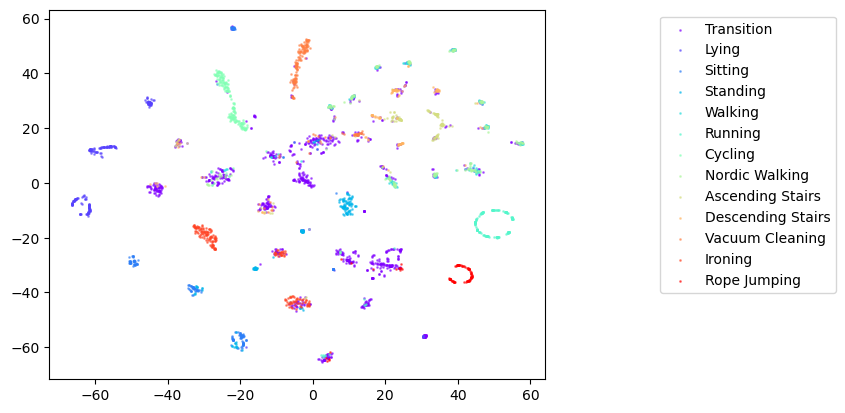

In [108]:
plt.style.use('default')
clustering_output = []
for ts in data_loader:
    recon = deep_cluster_model.AE.encode((ts.float().to(device)))
    clustering_output.append( recon.cpu().detach().numpy() ) 
    

clustering_output = [item for sublist in clustering_output for item in sublist]
?
clustering_output = np.asarray(clustering_output)
clustering_output_f = []
for i,co in enumerate(clustering_output):
    clustering_output[i].flatten()
    clustering_output_f.append(clustering_output[i].flatten())
clustering_output_f = np.asarray(clustering_output_f)

activities = []
activities.append(labels[0])
for l in labels:
    if l != activities[-1]:
        activities.append(int(l))


activity_names = ['Transition',
                  'Lying',
                  'Sitting',
                  'Standing',
                  'Walking',
                  'Running',
                  'Cycling',
                  'Nordic Walking',
                  '8',
                  'Watching TV',
                  'Computer Work',
                  'Car Driving',
                  'Ascending Stairs',
                  'Descending Stairs',
                  '14',
                  '15',
                  'Vacuum Cleaning',
                  'Ironing',
                  'Folding Laundry',
                  'House Cleaning',
                  'Playing Soccer',
                  '21',
                  '22',
                  '23',
                  'Rope Jumping']

X_embedded = TSNE(n_components=2).fit_transform(clustering_output_f)

cmap = plt.get_cmap('rainbow')

l = np.unique(labels)
slicedCM = cmap(np.linspace(0, 1, len(l))) 



for m,la in enumerate(l): 
    ind = np.where(subsequence_labels==la)
    plt.scatter(X_embedded[ind,0],X_embedded[ind,1],color=slicedCM[m], label=activity_names[int(la)], alpha=0.5, s=1)

plt.legend(loc=1, bbox_to_anchor=(1.1, 0., 0.5, 1.0))

## Remove Duplicate Cluster Labels and Set Labels in Sequential Order

In [109]:
while ( (not all(l[i] == l[i+1] -1 for i in range(len(l) - 1))) or (l[0] != 0) ):
    for assignment in range(np.max(cluster_assignments)+1):
        if assignment not in cluster_assignments:
            indx = np.where(cluster_assignments > assignment)
            cluster_assignments[indx] = cluster_assignments[indx]-1
    l = np.unique(cluster_assignments)

## Phase 3: Sldiing Window on Cluster Labels

In [110]:
window_length2 = 30
similarities = get_label_score(cluster_assignments, window_length2)


## Normalize and Smooth Sliding Window Distance

In [111]:
data = (similarities - np.min(similarities)) / (np.max(similarities) - np.min(similarities))
data = smooth(np.blackman(50), data)

In [112]:
peaks, peak_data = find_peaks(data, height=0.6,distance=window_length2//2,prominence=0.1)
real_peaks = peaks+window_length2//2
predictions = get_changepoints(real_peaks, window_length, overlap_percent)


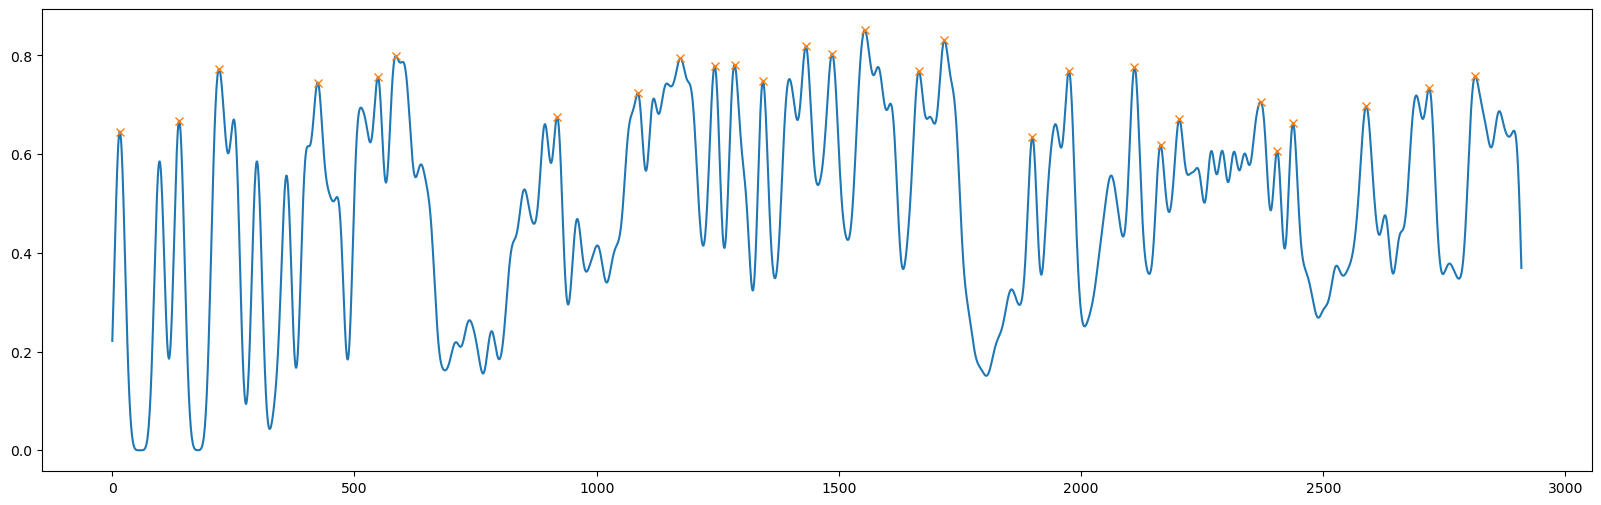

Space: Encoded Hidden Space
Clusters = 80


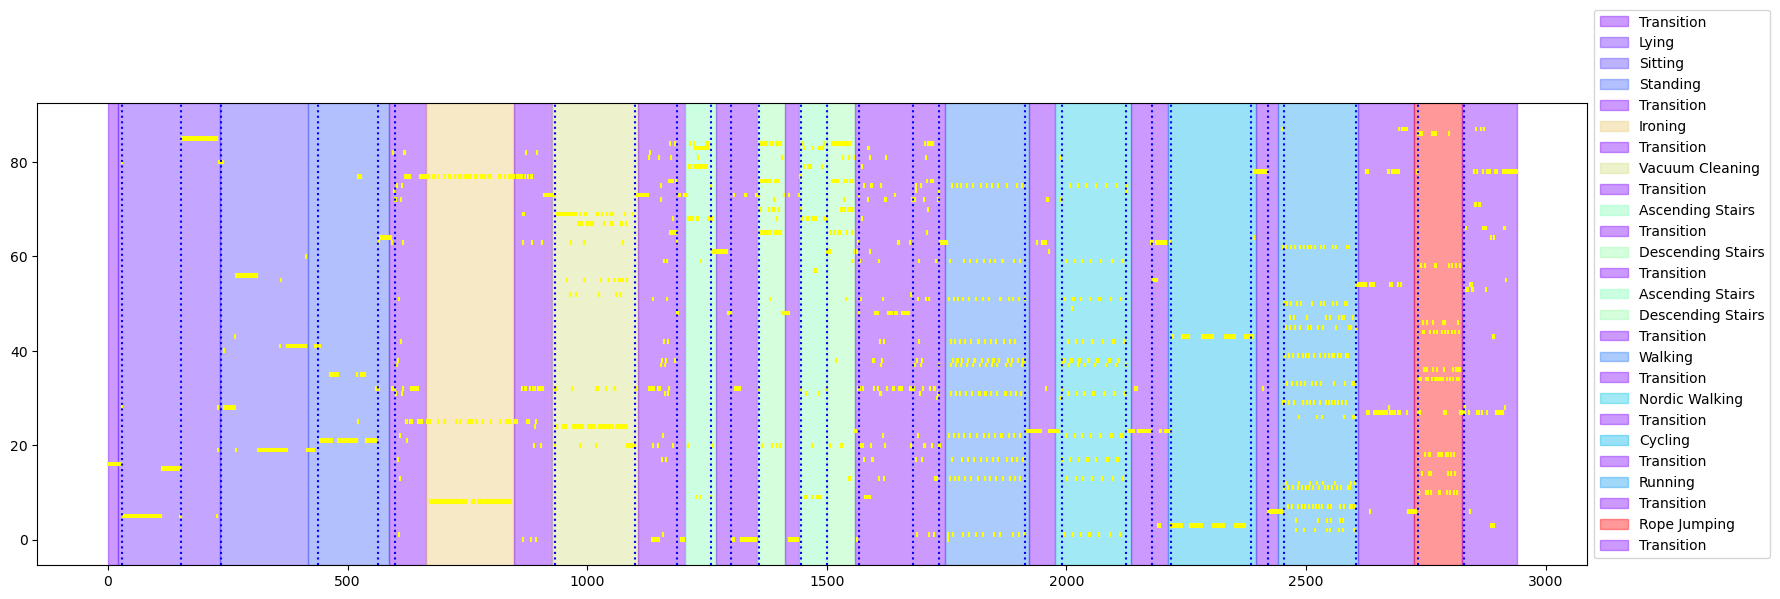

covering score: 0.7389659725286901
margin: 3000
f_measure score: (0.8363636363636363, 0.7931034482758621, 0.8846153846153846)


In [113]:
plt.style.use('https://raw.githubusercontent.com/TDAmeritrade/stumpy/main/docs/stumpy.mplstyle')
cmap = plt.get_cmap('rainbow')

l = np.unique(labels)


slicedCM = cmap(np.linspace(0, 1, len(activity_names))) 


plt.plot(data)
plt.plot(peaks, data[peaks], "x")
plt.show()

positions = np.arange(len(cluster_assignments))[:,np.newaxis]

plt.eventplot(positions, lineoffsets=cluster_assignments, color = [(1.0,1.0,0.0)])

for vline in real_peaks:
    plt.axvline(x = vline, color = 'b', linestyle=':', mfc='b')

start = 0
subsequence_ground_truth = np.where(subsequence_labels[:-1] != subsequence_labels[1:])[0]
print("Space: Encoded Hidden Space\nClusters = {}".format(n_clusters))
for i, activity in enumerate(activities):
    if i == len(activities):
        continue
    if i == len(activities)-1:
        end = len(subsequence_labels)
    else:
        end = subsequence_ground_truth[i]

    plt.axvspan(start, end, alpha=0.4, color=slicedCM[int(activity)], label=activity_names[int(activity)])
    plt.legend(loc=3, bbox_to_anchor=(1, 0, 0, 1.0))
    start = end
plt.show()

print('covering score:',covering(ground_truth, predictions, len(labels)))
margin = 100*30
print('margin:',margin)
print('f_measure score:',f_measure(ground_truth, predictions, margin=margin, alpha=0.5, return_PR=True))